In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mogptk.gpr.kernel import MultiOutputKernel
from mogptk.gpr.kernel import ChangePointsKernel
from mogptk.gpr.singleoutput import RationalQuadraticKernel, SquaredExponentialKernel
from mogptk import Data, Model
from mogptk.gpr.likelihood import LaplaceLikelihood, GaussianLikelihood, \
    StudentTLikelihood
from mogptk.gpr import ConstantMean, LinearMean
from mogptk import Exact, Hensman, Titsias, LoadDataFrame, Model, TransformDetrend, TransformStandard

In [2]:
np.random.seed(1410)

Data Generation

In [3]:
# # input 1D
# nt = 10**3
# a, b = -20., 20.
# t_irreg = np.random.uniform(a, b, size=nt).sort()
# y_useless = np.random.normal(size=nt)

# # just to instantiate a mogptk.Model, independent of input
# data = Data(X=t_irreg, Y=y_useless, y_label='placeholder')

In [4]:
df = pd.read_csv('../examples/data/AirQualityUCI.csv', sep=';', skiprows=lambda i: i>=9358)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S')
df['timestamp'] = df[['Date', 'Time']].agg(
    func=lambda row: pd.Timestamp.combine(row['Date'], row['Time'].time()),
    axis=1
)
cols_meas = ['CO(GT)', 
           'PT08.S1(CO)',
           'NMHC(GT)', 
           'C6H6(GT)',
           'PT08.S2(NMHC)',
           'NOx(GT)', 
           'PT08.S3(NOx)', 
           'NO2(GT)', 
           'PT08.S4(NO2)', 
           'PT08.S5(O3)']
# Replace missing values with NaN
df = df.replace([-200, 200.0], np.nan, inplace=False)

# Downsampling
target_freq = pd.Timedelta(days=1)
df = df.resample(target_freq, on='timestamp', closed='left', label='right', origin='start').mean()
df.reset_index(drop=False, inplace=True)

# 
df['timestamp'] = (df['timestamp'] - df['timestamp'].iloc[0]) / target_freq
# df['timestamp']
df.drop(columns=['Date', 'Time'], inplace=True)

data = LoadDataFrame(
    df, x_col=['timestamp'],
    y_col=cols_meas
)

In [5]:
target_freq.__str__()

'1 days 00:00:00'

In [6]:
df.isna().sum()

timestamp          0
CO(GT)            36
PT08.S1(CO)        9
NMHC(GT)         347
C6H6(GT)           9
PT08.S2(NMHC)      9
NOx(GT)           33
PT08.S3(NOx)       9
NO2(GT)           33
PT08.S4(NO2)       9
PT08.S5(O3)        9
T                  9
RH                 9
AH                 9
Unnamed: 15      390
Unnamed: 16      390
dtype: int64

In [7]:
data['NOx(GT)']

     timestamp     NOx(GT)
0          0.0  118.130435
1          1.0  165.590909
2          2.0  189.782609
3          3.0  154.913043
4          4.0  201.434783
..         ...         ...
352      385.0  232.434783
353      386.0  150.791667
354      387.0  153.750000
355      388.0  138.291667
356      389.0  261.904762

[357 rows x 2 columns]

Obvious change in time around 2004-September

In [8]:
data_nox = data['NOx(GT)']
data_nox.remove(pct=0.25)
data_nox.transform(TransformDetrend(degree=1))
data_nox.transform(TransformStandard())

<Axes: title={'center': 'NOx(GT)'}, xlabel='timestamp', ylabel='NOx(GT)'>

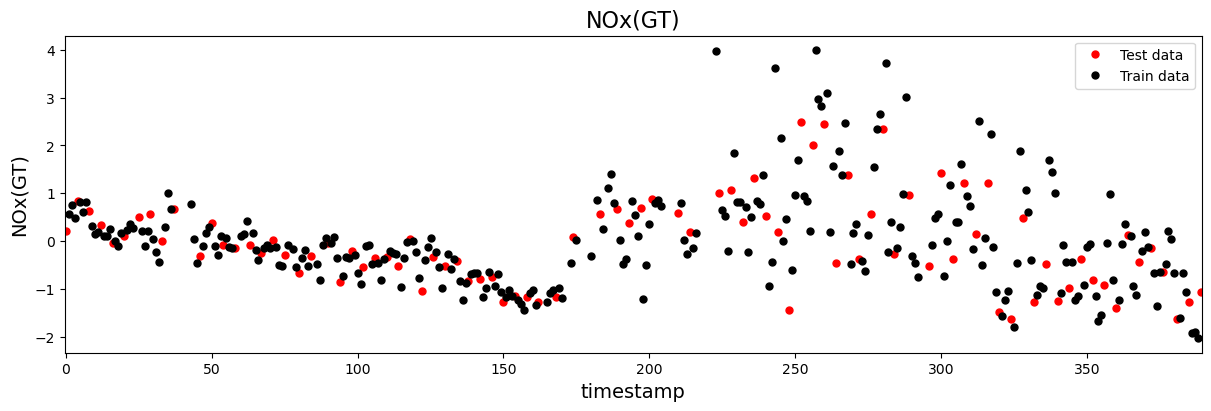

In [9]:
data_nox.plot(transformed=True)

In [10]:
np.diff(data_nox.get_data(transformed=True)[1].flatten())

array([ 3.67235575e-01,  1.84157761e-01, -2.80533971e-01,  3.59849643e-01,
       -2.05491706e-02, -2.12459004e-01,  2.24041793e-01, -1.97065167e-01,
       -3.20215862e-01, -1.71408772e-01,  4.58153706e-02,  1.50151376e-01,
       -2.29563267e-01, -7.54993056e-03,  1.60756019e-01, -3.04479940e-01,
        4.85520528e-02, -1.13596362e-01,  2.87078778e-01, -6.44293804e-02,
        1.13206168e-01,  1.23468726e-01, -8.37209160e-02,  2.32199278e-01,
       -2.85750772e-01, -3.17479180e-01,  3.09221024e-01,  3.64980922e-01,
       -5.18283230e-01, -2.79507716e-01, -2.14169430e-01,  4.44344703e-01,
        2.87802686e-01,  7.22479028e-01, -3.43629698e-01,  8.12153675e-04,
        1.02381841e-01, -7.20508249e-01, -5.09731098e-01,  1.49125120e-01,
        2.17884258e-01,  2.62697428e-01,  1.31678772e-01,  7.07875949e-02,
       -4.73127975e-01, -1.99117678e-01,  3.97479022e-01, -1.87828865e-01,
        1.64363464e-01, -1.92462565e-01, -3.32063254e-02, -8.60263172e-04,
        2.70009202e-01,  

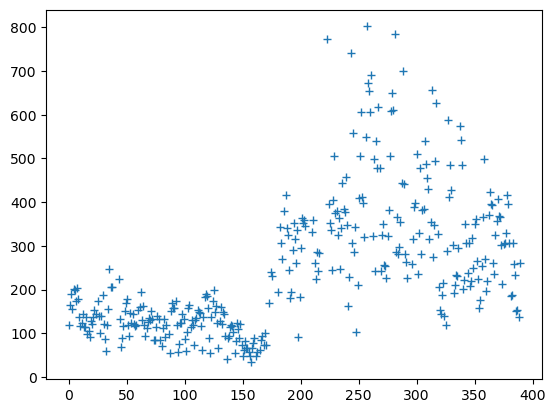

In [11]:
plt.plot(
    data_nox.get_data()[0],
    data_nox.get_data()[1],
    linestyle='None',
    marker='+'
)

Model + kernel specification

In [12]:
# Observation model
lik = StudentTLikelihood(dof=2, scale=0.1)

# Kernel
# initial guess for change location:
# np.where(data_nox.get_data()[1] >= 200) => index at 160 equiv to X~303900
cp_loc_guess = 160.0
k1 = SquaredExponentialKernel()
k2 = SquaredExponentialKernel()
kernel = ChangePointsKernel(
    [cp_loc_guess],
    1.5,
    k1, k2
)

# Model
model = Model(
    dataset=data_nox,
    kernel=kernel,
    mean=ConstantMean(),
    inference=Hensman(inducing_points=10, init_inducing_points='density', likelihood=lik)
)

In [13]:
lik.scale.assign(value=0.5, train=False)
# # hyperparams init
# for k in [k1, k2]:
#     k.magnitude.assign(value=1.0, train=False)
kernel.locations.assign(value=cp_loc_guess, train=True)

Training

Starting optimization using Adam
‣ Model: SparseHensman
  ‣ Kernel: [SquaredExponentialKernel,SquaredExponentialKernel]
  ‣ Likelihood: StudentTLikelihood
  ‣ Mean: ConstantMean
‣ Channels: 1
‣ Parameters: 83
‣ Training points: 268
‣ Iterations: 10000
      0/10000   0:00:01  loss=     9618.07 (warmup)
    687/10000   0:00:10  loss=     9558.28
    958/10000   0:00:20  loss=     9559.08
   1702/10000   0:00:30  loss=     10104.8
   2550/10000   0:00:40  loss=     9700.15
   3344/10000   0:00:50  loss=     9524.51
   4096/10000   0:01:00  loss=      9698.8
   4676/10000   0:01:10  loss=     10233.5
   5648/10000   0:01:20  loss=     9549.57
   6580/10000   0:01:30  loss=     9893.28
   7579/10000   0:01:40  loss=     9961.02
   8572/10000   0:01:50  loss=     9885.64
   9487/10000   0:02:00  loss=     9810.92
  10000/10000   0:02:05  loss=     9483.11
Optimization finished in 2 minutes 5 seconds


Name,Range,Value
SparseHensman.q_mu,"(-∞, ∞)",[[-0.73944692] [-1.43159065] [-4.7188734 ] [ 3.13539486] [-0.20677048] [-2.73208541] [-0.9502183 ] [-0.48090363] [ 1.89833814] [ 1.62731983]]
SparseHensman.q_sqrt,"(-∞, ∞)",[[-2.46251482e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [-5.87150251e-02 1.26634757e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [-5.60771165e-01 -5.35332159e-06 -1.88293654e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [ 5.70942268e-05 1.53869497e+00 -1.53869543e+00 2.23170497e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [-1.91694239e-03 1.90228605e-01 -1.46437944e-03 -7.04393033e-04 -8.83864178e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [ 1.91775262e-03 1.59099000e-12 4.55063872e-01 1.32345172e+00 -9.91560476e-01 -1.07931456e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [-8.79209302e-01 1.41807322e+00 1.45808789e+00 -6.76352829e-01 7.88982569e-01 3.68963648e+00 -9.54821759e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00] [-6.00550416e-04 1.28829784e+00 1.37009643e-01 -6.33869166e-03 -1.39636072e+00 -6.47132306e-03 -4.78234356e-07 -1.02237012e+00 0.00000000e+00 0.00000000e+00] [ 2.35655793e-01 2.35655784e-01 -2.35655784e-01 6.19161951e-01 -2.47591252e-01 -9.69075179e-01 -9.69075179e-01 -2.55298792e-01 9.47101051e-01 0.00000000e+00] [-5.61784323e-03 -7.91009558e-02 7.85661924e-02 2.50405479e-02 4.60009722e-06 -2.71110358e-02 3.14723485e-02 -1.35354298e-02 -2.92302883e-03 1.46124848e+00]]
induction_points,"(-∞, ∞)",[[232.30171782] [133.71233984] [169.36598573] [258.30485165] [ 58.10689207] [112.60588583] [ 98.35550236] [ 16.79031182] [346.27429884] [185.66024156]]
ChangePointsKernel.locations,"(-∞, ∞)",[154.09774563]
ChangePointsKernel.steepness,"[1e-08, ∞)",1.577197195725175
ChangePointsKernel[0].SquaredExponentialKernel.magnitude,"[1e-08, ∞)",0.28489535799344795
ChangePointsKernel[0].SquaredExponentialKernel.lengthscale,"[1e-08, ∞)",[0.83075735]
ChangePointsKernel[1].SquaredExponentialKernel.magnitude,"[1e-08, ∞)",0.5735432479113467
ChangePointsKernel[1].SquaredExponentialKernel.lengthscale,"[1e-08, ∞)",[1.8001948]
ConstantMean.bias,"(-∞, ∞)",0.11635890348146968


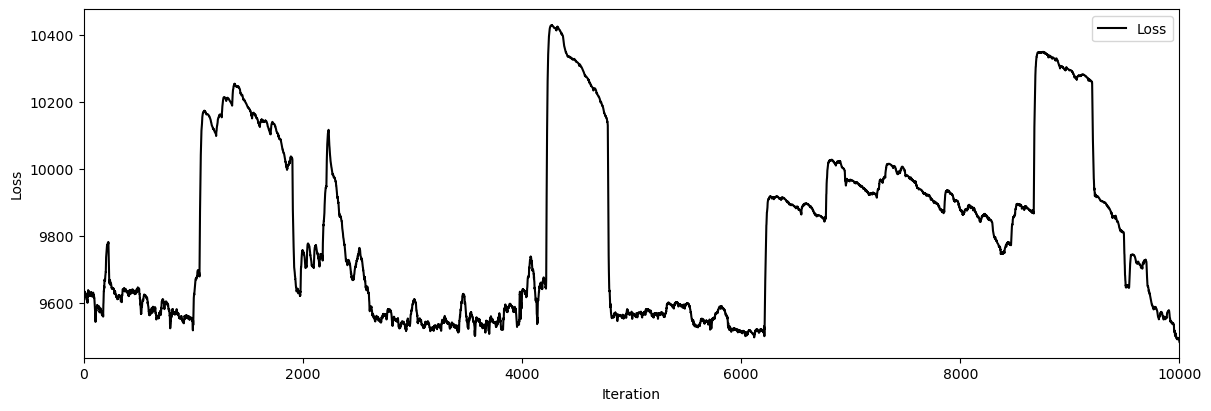

In [14]:
model.train(method='adam', lr=5e-2, iters=10**4, plot=True, verbose=True)
model.print_parameters()

(-0.389, 389.389)

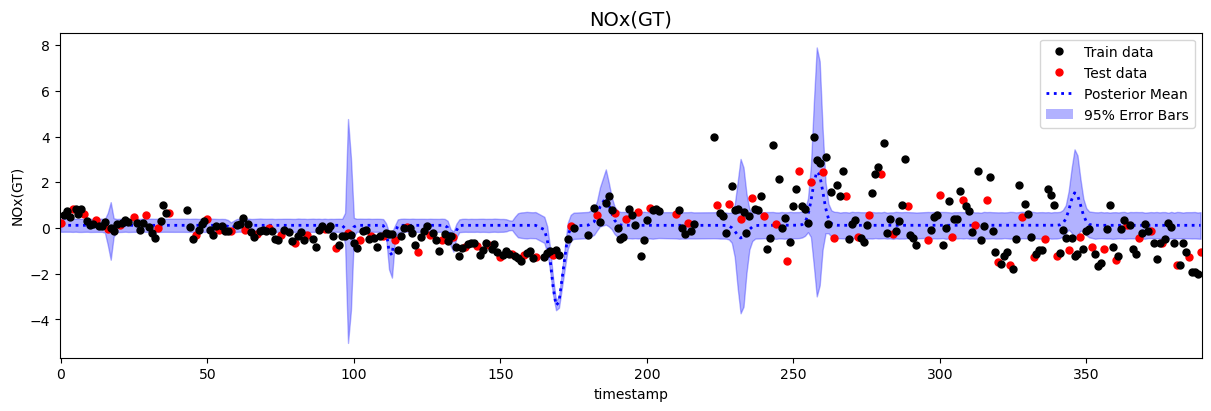

In [15]:
fig, ax = model.plot_prediction(transformed=True, sigma=1)
# ax[0, 0].vlines(, ymin=-3, ymax=3, linestyle='solid', color='brown')
ax[0, 0].get_xbound()